In [0]:
# Databricks Notebook: Outlier Detection

# Import necessary libraries
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("OutlierDetection").getOrCreate()

# Load dataset from Databricks table
df = spark.sql("SELECT * FROM default.sfr_test_csv")

# Show dataset schema
df.printSchema()


root
 |-- member_unique_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- eligible_year: string (nullable = true)
 |-- eligible_month: string (nullable = true)
 |-- affiliation_type: string (nullable = true)
 |-- pbp_group: string (nullable = true)
 |-- plan_name: string (nullable = true)
 |-- npi: string (nullable = true)
 |-- line_of_business: string (nullable = true)
 |-- esrd: string (nullable = true)
 |-- hospice: string (nullable = true)
 |-- ipa_funding: string (nullable = true)
 |-- ma_premium: string (nullable = true)
 |-- ma_risk_score: string (nullable = true)
 |-- mbr_with_rx_rebates: string (nullable = true)
 |-- partd_premium: string (nullable = true)
 |-- pcp_cap: string (nullable = true)
 |-- pcp_ffs: string (nullable = true)
 |-- plan_premium: string (nullable = true)
 |-- prof: string (nullable = true)
 |-- reinsurance: string (nullable = true)
 |-- risk_score_partd: string (nullable = true)
 |-- rx: string (nul

In [0]:
# Show first few rows
df.show(5)

+----------------+------+----------+-------------+--------------+----------------+---------+--------------------+---+----------------+-----+-------+-----------+----------+-------------+-------------------+-------------+-------+-------+------------+---------+-----------+----------------+----------+----------+---------------+------------------+--------+
|member_unique_id|gender|       dob|eligible_year|eligible_month|affiliation_type|pbp_group|           plan_name|npi|line_of_business| esrd|hospice|ipa_funding|ma_premium|ma_risk_score|mbr_with_rx_rebates|partd_premium|pcp_cap|pcp_ffs|plan_premium|     prof|reinsurance|risk_score_partd|        rx|rx_rebates|rx_with_rebates|rx_without_rebates|spec_cap|
+----------------+------+----------+-------------+--------------+----------------+---------+--------------------+---+----------------+-----+-------+-----------+----------+-------------+-------------------+-------------+-------+-------+------------+---------+-----------+----------------+-----

In [0]:
from pyspark.sql.functions import col, regexp_replace, to_date, substring

# Convert 'dob' to proper date format
df = df.withColumn("dob", to_date(col("dob"), "dd/MM/yyyy"))

# Extract month from 'eligible_month' (format: YYYYMM -> MM)
df = df.withColumn("eligible_month", substring(col("eligible_month"), 5, 2).cast("int"))

# Identify columns containing financial values (with "$") and convert them to float
num_cols = [col_name for col_name in df.columns if df.select(col_name).first()[0] and "$" in str(df.select(col_name).first()[0])]

for col_name in num_cols:
    df = df.withColumn(col_name, regexp_replace(col(col_name), "[$,]", "").cast("double"))

# Identify numeric columns stored as strings and convert to appropriate types
for col_name in df.columns:
    sample_value = df.select(col_name).first()[0]
    if isinstance(sample_value, str) and sample_value.replace(".", "", 1).isdigit():
        df = df.withColumn(col_name, col(col_name).cast("double"))

# Show updated schema after conversion
df.printSchema()

# Show first few rows after conversion
df.show(5)


root
 |-- member_unique_id: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- eligible_year: double (nullable = true)
 |-- eligible_month: integer (nullable = true)
 |-- affiliation_type: string (nullable = true)
 |-- pbp_group: string (nullable = true)
 |-- plan_name: string (nullable = true)
 |-- npi: double (nullable = true)
 |-- line_of_business: string (nullable = true)
 |-- esrd: string (nullable = true)
 |-- hospice: string (nullable = true)
 |-- ipa_funding: double (nullable = true)
 |-- ma_premium: double (nullable = true)
 |-- ma_risk_score: double (nullable = true)
 |-- mbr_with_rx_rebates: double (nullable = true)
 |-- partd_premium: double (nullable = true)
 |-- pcp_cap: double (nullable = true)
 |-- pcp_ffs: double (nullable = true)
 |-- plan_premium: double (nullable = true)
 |-- prof: double (nullable = true)
 |-- reinsurance: double (nullable = true)
 |-- risk_score_partd: double (nullable = true)
 |-- rx: double (null

In [0]:
from pyspark.sql.functions import mean, stddev, col, percentile_approx
from functools import reduce

# Identify financial columns (numeric columns excluding categorical fields)
financial_cols = [
    "ipa_funding", "ma_premium", "ma_risk_score", "mbr_with_rx_rebates",
    "partd_premium", "pcp_cap", "pcp_ffs", "plan_premium", "prof", 
    "reinsurance", "risk_score_partd", "rx", "rx_rebates", "rx_with_rebates", 
    "rx_without_rebates", "spec_cap"
]

# Compute mean and standard deviation for Z-score calculation
stats = df.select(
    *[mean(col(c)).alias(f"{c}_mean") for c in financial_cols],
    *[stddev(col(c)).alias(f"{c}_std") for c in financial_cols]
).collect()[0]

# Define a threshold for Z-score (commonly 3.0)
z_threshold = 3.0

# Detect outliers using Z-score method (with zero stddev handling)
outlier_conditions = [
    ((col(c) - stats[f"{c}_mean"]) / stats[f"{c}_std"] > z_threshold) 
    if stats[f"{c}_std"] > 0 else col(c).isNotNull()
    for c in financial_cols
]

# Use reduce to efficiently combine conditions (instead of multiple unions)
df_outliers_zscore = df.filter(reduce(lambda x, y: x | y, outlier_conditions))

print(f"Number of outliers detected using Z-score: {df_outliers_zscore.count()}")

# Detect outliers using IQR method
iqr_threshold = 1.5  # Standard IQR multiplier for outlier detection
outlier_conditions_iqr = []

for c in financial_cols:
    q1, q3 = df.approxQuantile(c, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - (iqr_threshold * iqr)
    upper_bound = q3 + (iqr_threshold * iqr)

    if q3 > q1:  # Ensure IQR calculation is valid
        outlier_conditions_iqr.append((col(c) < lower_bound) | (col(c) > upper_bound))

# Use reduce to efficiently combine conditions
df_outliers_iqr = df.filter(reduce(lambda x, y: x | y, outlier_conditions_iqr))

print(f"Number of outliers detected using IQR: {df_outliers_iqr.count()}")

# Show a sample of outliers detected
df_outliers_zscore.show(5)
df_outliers_iqr.show(5)


Number of outliers detected using Z-score: 10530
Number of outliers detected using IQR: 4250
+----------------+------+----------+-------------+--------------+----------------+---------+--------------------+---+----------------+-----+-------+-----------+----------+-------------+-------------------+-------------+-------+-------+------------+------+-----------+----------------+--------+----------+---------------+------------------+--------+
|member_unique_id|gender|       dob|eligible_year|eligible_month|affiliation_type|pbp_group|           plan_name|npi|line_of_business| esrd|hospice|ipa_funding|ma_premium|ma_risk_score|mbr_with_rx_rebates|partd_premium|pcp_cap|pcp_ffs|plan_premium|  prof|reinsurance|risk_score_partd|      rx|rx_rebates|rx_with_rebates|rx_without_rebates|spec_cap|
+----------------+------+----------+-------------+--------------+----------------+---------+--------------------+---+----------------+-----+-------+-----------+----------+-------------+-------------------+----

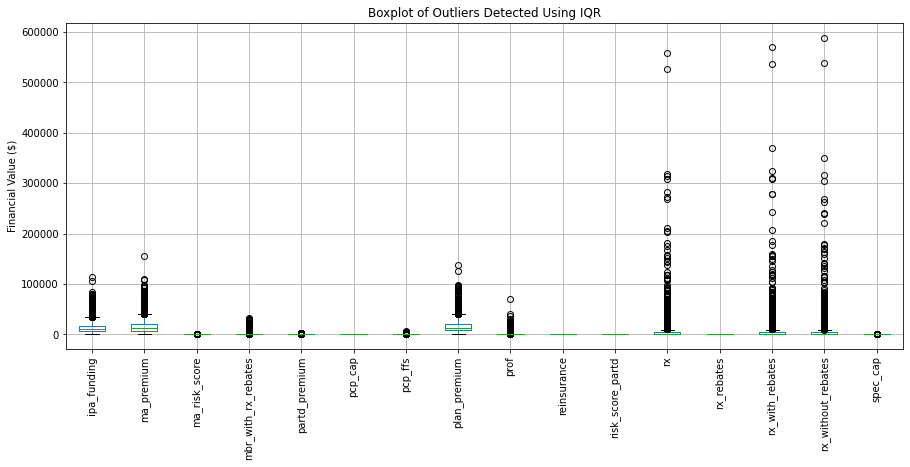

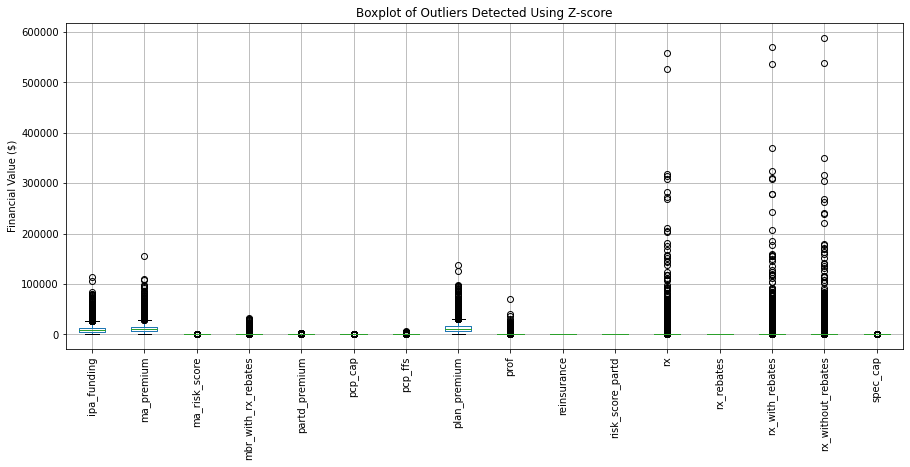

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas for visualization
df_outliers_iqr_pd = df_outliers_iqr.toPandas()
df_outliers_zscore_pd = df_outliers_zscore.toPandas()

# Define financial columns for visualization
financial_cols = [
    "ipa_funding", "ma_premium", "ma_risk_score", "mbr_with_rx_rebates",
    "partd_premium", "pcp_cap", "pcp_ffs", "plan_premium", "prof", 
    "reinsurance", "risk_score_partd", "rx", "rx_rebates", "rx_with_rebates", 
    "rx_without_rebates", "spec_cap"
]

# Generate boxplots for key financial metrics (for IQR-detected outliers)
plt.figure(figsize=(15, 6))
df_outliers_iqr_pd[financial_cols].boxplot(rot=90)
plt.title("Boxplot of Outliers Detected Using IQR")
plt.ylabel("Financial Value ($)")
plt.show()

# Generate boxplots for key financial metrics (for Z-score-detected outliers)
plt.figure(figsize=(15, 6))
df_outliers_zscore_pd[financial_cols].boxplot(rot=90)
plt.title("Boxplot of Outliers Detected Using Z-score")
plt.ylabel("Financial Value ($)")
plt.show()

# Summarize outliers by financial column
outliers_summary = {
    "Financial Column": financial_cols,
    "IQR Outliers": [df_outliers_iqr_pd[col].count() for col in financial_cols],
    "Z-score Outliers": [df_outliers_zscore_pd[col].count() for col in financial_cols],
}

# Convert to Pandas DataFrame for better readability
outliers_summary_df = pd.DataFrame(outliers_summary)



In [0]:
from pyspark.sql.functions import col, expr

def detect_outliers(df, column):
    # Calculate Q1, Q3, and IQR
    q1_q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)
    if len(q1_q3) < 2:
        return None  # Skip if not enough data
    
    Q1, Q3 = q1_q3
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count total rows and outliers
    total_count = df.count()
    outlier_count = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    
    # Compute percentage
    outlier_percentage = (outlier_count / total_count) * 100 if total_count > 0 else 0
    return (column, outlier_percentage)

# Identify numeric columns
numeric_cols = [col_name for col_name in df.columns if df.select(col_name).schema.fields[0].dataType.simpleString() in ["int", "double"]]

# Compute outlier percentages for each numeric column
outlier_results = [detect_outliers(df, col_name) for col_name in numeric_cols]
outlier_results = [res for res in outlier_results if res is not None]

# Convert results to DataFrame for easy visualization
outlier_df = spark.createDataFrame(outlier_results, ["Column", "Outlier_Percentage"])
outlier_df.show()

+-------------------+------------------+
|             Column|Outlier_Percentage|
+-------------------+------------------+
|   member_unique_id|               0.0|
|      eligible_year|               0.0|
|     eligible_month|               0.0|
|                npi|               0.0|
|        ipa_funding| 4.795821462488129|
|         ma_premium|   4.9002849002849|
|      ma_risk_score|4.6248812915479585|
|mbr_with_rx_rebates| 7.730294396961064|
|      partd_premium| 5.251661918328585|
|            pcp_cap|20.721747388414055|
|            pcp_ffs|3.9601139601139606|
|       plan_premium|4.8907882241215574|
|               prof| 17.54036087369421|
|        reinsurance|               0.0|
|   risk_score_partd|               0.0|
|                 rx|15.698005698005698|
|         rx_rebates|               0.0|
|    rx_with_rebates|15.716999050332383|
| rx_without_rebates|15.754985754985753|
|           spec_cap| 2.184235517568851|
+-------------------+------------------+

